In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import scipy.sparse as sps
import sklearn.neighbors as nbrs
import torch
import torch.optim as optim
import torch.nn as nn
import torch_sparse as tsps
import torch_scatter as tsct
import torch_geometric.nn as gnn
import torch_geometric

from surprise import Dataset, KNNBasic
from surprise.model_selection import KFold

/home/euler/anaconda3/envs/torch/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/euler/anaconda3/envs/torch/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/euler/anaconda3/envs/torch/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/euler/anaconda3/envs/torch/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/euler/anaconda3/envs/torch/lib/python3.7/importlib/_bootstrap.py:219: 

In [2]:
item = 'u.item'
url = 'http://files.grouplens.org/datasets/movielens/ml-100k/%s' % item
r = requests.get(url, stream=True)
print('downloading file...')
with open(item, 'w') as fd:
    for content in r.iter_content():
        fd.write(str(content, encoding='latin1'))
item_features = pd.read_csv('u.item', sep='|', header=None, names=[
    'movie id', 'movie title', 'release date', 'video release date',
    'IMDb URL', 'unknown', 'Action', 'Adventure', 'Animation',
    'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 
    'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 
    'Sci-Fi', 'Thriller', 'War', 'Western'])
item_features.drop(columns=['video release date', 'IMDb URL'], inplace=True)
print('done!')

downloading file...
done!


In [34]:
item_features

,movie id,movie title,release date,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
5,6,Shanghai Triad (Yao a yao yao dao waipo qiao) ...,01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,7,Twelve Monkeys (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
7,8,Babe (1995),01-Jan-1995,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
8,9,Dead Man Walking (1995),01-Jan-1995,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,10,Richard III (1995),22-Jan-1996,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [19]:
features = item_features[['unknown', 'Action', 'Adventure', 'Animation',
    'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 
    'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 
    'Sci-Fi', 'Thriller', 'War', 'Western']]
algo = nbrs.NearestNeighbors(n_neighbors=11).fit(features)
WA = nbrs.kneighbors_graph(features, n_neighbors=10)
np.argwhere(WA[0:5].toarray() > 0)[:40:2]

array([[   0,   94],
       [   0,  168],
       [   0,  224],
       [   0,  242],
       [   0,  260],
       [   1,  116],
       [   1,  565],
       [   1,  929],
       [   1, 1012],
       [   1, 1104],
       [   2,  197],
       [   2,  358],
       [   2,  594],
       [   2,  772],
       [   2,  974],
       [   3,   73],
       [   3,  387],
       [   3,  455],
       [   3,  685],
       [   3,  788]])

In [23]:
kf = KFold(n_splits=5)
movielens = Dataset.load_builtin('ml-100k')
train, test = next(kf.split(movielens))

In [56]:
test

[('112', '1106', 4.0),
 ('252', '410', 5.0),
 ('85', '87', 4.0),
 ('151', '836', 4.0),
 ('1', '103', 1.0),
 ('931', '286', 5.0),
 ('234', '170', 5.0),
 ('474', '566', 5.0),
 ('624', '924', 4.0),
 ('474', '943', 4.0),
 ('201', '692', 3.0),
 ('361', '794', 3.0),
 ('340', '186', 4.0),
 ('916', '498', 3.0),
 ('414', '301', 3.0),
 ('673', '310', 5.0),
 ('848', '855', 5.0),
 ('113', '273', 4.0),
 ('312', '615', 4.0),
 ('782', '1394', 4.0),
 ('457', '717', 3.0),
 ('12', '242', 5.0),
 ('189', '21', 2.0),
 ('864', '137', 4.0),
 ('14', '70', 1.0),
 ('244', '95', 4.0),
 ('936', '14', 4.0),
 ('527', '203', 4.0),
 ('314', '393', 4.0),
 ('889', '955', 3.0),
 ('882', '291', 4.0),
 ('567', '1019', 5.0),
 ('889', '190', 3.0),
 ('592', '678', 2.0),
 ('378', '1101', 3.0),
 ('726', '763', 2.0),
 ('757', '1016', 3.0),
 ('862', '257', 5.0),
 ('445', '64', 2.0),
 ('557', '50', 4.0),
 ('54', '827', 3.0),
 ('621', '107', 4.0),
 ('590', '287', 4.0),
 ('144', '72', 4.0),
 ('104', '591', 4.0),
 ('200', '892', 4.0

In [55]:
train.all_items()
train.all_users()

range(0, 943)

In [57]:
i, j, data = zip(*train.all_ratings())
X = sps.coo_matrix((data, (i, j)))
i, j, data = zip(*test)
i = [int(ia) for ia in i]
j = [int(ja) for ja in j]
Y = sps.coo_matrix((data, (i, j)))

In [52]:
Y.shape

(944, 1682)

In [64]:
X = sps.coo_matrix((data, (i, j)))
HA = nbrs.kneighbors_graph(X, n_neighbors=10)
np.argwhere(HA[0:5].toarray() > 0)[:40:2]

array([[  0,  93],
       [  0, 278],
       [  0, 461],
       [  0, 685],
       [  0, 873],
       [  1,   0],
       [  1,  71],
       [  1, 153],
       [  1, 359],
       [  1, 857],
       [  2, 147],
       [  2, 282],
       [  2, 485],
       [  2, 657],
       [  2, 775],
       [  3,   0],
       [  3, 278],
       [  3, 502],
       [  3, 570],
       [  3, 775]])

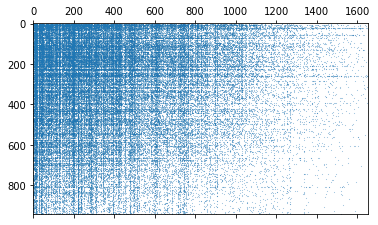

In [26]:
plt.spy(X, precision='present', markersize=0.1)

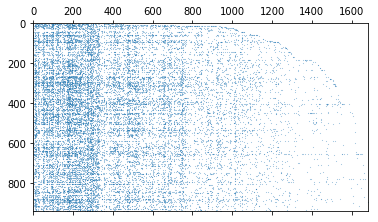

In [45]:
plt.spy(Y, precision='present', markersize=0.1)

In [78]:
# density
len(X.data) / np.product(X.shape)

0.05147793141080419

In [76]:
U, Sigma, V = sps.linalg.svds(X, k=10)
H = U * Sigma
W = V.T * Sigma

HA = sps.coo_matrix(HA)
WA = sps.coo_matrix(WA)

Xtest = X.copy()
Xtest.resize(Y.shape)

In [30]:
# for computation of loss
def frobenius_norm(x):
    """norm for matrices"""
    x2 = x ** 2
    x2sum = torch.sum(x2)
    return torch.sqrt(x2sum)

def graph_norm(X, edge_index, edge_weights):
    lap = graph_laplacian(X, edge_index, edge_weights)
    norm = tsps.spmm(tsps.spmm(X, laplacian), tsps.transpose(X))

def graph_laplacian(X, edge_index, edge_weights):
    edge_index, edge_weight = remove_self_loops(edge_index, edge_weight)

    row, col = edge_index
    num_nodes = x.size(0)

    if edge_weight is None:
        edge_weight = x.new_ones((num_edges, ))
    edge_weight = edge_weight.view(-1)
    assert edge_weight.size(0) == edge_index.size(1)

    deg = torch_geometric.utils.degree(row, num_nodes, dtype=x.dtype)

    # Compute normalized and rescaled Laplacian.
    deg = deg.pow(-0.5)
    deg[deg == float('inf')] = 0
    lap = -deg[row] * edge_weight * deg[col]
    
    return lap

def recommender_loss(inputs, adjacency, target, gamma=1e-10):
    # loss function borrowed from objective in Srebro et. al 2004.
    H, W = inputs
    HA, WA = adjacency
    X = X * W.T
    xm = (X - target)
    fnorm = frobenius_norm(xm)
    gH = graph_norm(H, HA)
    gW = graph_norm(W, WA)
    loss = fnorm + (gamma / 2) * (torch.trace(gH) + torch.trace(gW))
    return loss


In [68]:
class RGCNNFactorization(nn.Module):

    def __init__(self, input_shape, factorization_rank=10, n_channels=32,
                 basis_order=5, diffusion_time=10, hidden_cells=32,
                 lstm_layers=1, bidirectional=False):
        super().__init__()

        # GCNN parameters
        self.m = input_shape[0]
        self.n = input_shape[1]
        self.r = factorization_rank
        self.q = n_channels
        self.order = basis_order

        # LSTM parameters
        self.nH = hidden_cells
        self.T = diffusion_time
        self.n_layers = lstm_layers
        self.bidirectional = False

        # GCNNs for H, W matrices
        self.hconv = gnn.ChebConv(in_channels=self.r, out_channels=self.q,
                                  K=self.order)
        self.wconv = gnn.ChebConv(in_channels=self.r, out_channels=self.q,
                                  K=self.order)

        # RNN
        self.lstm = nn.LSTM(input_size=self.q, hidden_size=self.nH,
                            num_layers=self.n_layers, bidirectional=self.bidirectional)

        self.loss_fn = recommender_loss

    def init_hidden(self):
        return torch.zeros((1, self.q))

    def forward(self, H, W, HA, WA):
        hidden = self.init_hidden()
        for i in range(self.T):
            conv1 = self.hconv(H, HA)
            Htilde = torch.sigmoid(conv1)
            out, hidden = self.lstm(Htilde, hidden)
            dH = torch.tanh(out)
            H = H + dH

            conv2 = self.wconv(W, WA)
            Wtilde = torch.sigmoid(conv2)
            out, hidden = self.lstm(Wtilde, hidden)
            dW = torch.tanh(out)
            W = W + dW

        return H, W

    def train(self, H, W, HA, WA, Y, iters, optimizer=None):
        if optimizer is None:
            optimizer = optim.Adam(self.parameters())
        HA = torch.tensor([HA.row, HA.col])
        WA = torch.tensor([WA.row, WA.col])
        for i in range(iters):
            optimizer.zero_grad()
            H, W = self.forward(H, W, HA, WA)
            loss = self.loss_fn((H, W), (HA, WA), Y)
            loss.backward()
            optimizer.step()


In [69]:
model = RGCNNFactorization(X.shape)

In [77]:
model.train(H, W, HA, WA, Xtest + Y, 100)

TypeError: 'int' object is not callable

In [75]:
sps.coo_matrix(HA)

<944x944 sparse matrix of type '<class 'numpy.float64'>'
	with 9440 stored elements in COOrdinate format>

In [71]:
Xtest.row

array([  0,   0,   0, ..., 942, 942, 942], dtype=int32)